# Психотипирование по текстам

In [1]:
import sys
sys.path.append("../../")

In [2]:
import warnings
import matplotlib.pyplot as plt
import pickle
import logging
import pandas as pd
import json
import sys
import numpy as np
from morpholog import Morpholog
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel
from wordfreq import zipf_frequency
from IPython.display import display, Markdown
from matplotlib import rcParams
from pymystem3 import Mystem
from simple_elmo import ElmoModel
import stanza
import spacy
import snowballstemmer
import os
from collections import defaultdict
from termcolor import colored

logging.disable(sys.maxsize)

rcParams['mathtext.default'] = 'regular'
plt.style.use('seaborn-darkgrid')
warnings.filterwarnings("ignore")
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

%load_ext autoreload
%autoreload 2

In [3]:
from analytics_lib.nlp_texts.text import TextProcessor
from analytics_lib.nlp_texts.psychotype import *

In [4]:
mystem = Mystem()
nlp_core = stanza.Pipeline('ru', use_gpu=False, dir='./stanza_resources')
morpholog = Morpholog()
tokenizer = RegexTokenizer()
ftsnm = FastTextSocialNetworkModel(tokenizer=tokenizer)
nlp_spacy = spacy.load("ru_core_news_sm")
stemmer = snowballstemmer.stemmer('russian')

import tensorflow.compat.v1 as tf
tf.reset_default_graph()
elmo_model = ElmoModel()
elmo_model.load("./elmo_resources")

df_sense = pd.read_pickle("../data/df_sense.pkl") # df с чувственными прилагательными
verbs_df = pd.read_pickle("../data/verbs_df.pkl") # df c глаголами для внутренних и внешних предикатов

## Инициализируем объект TextProcessor() нашего класса по работе с текстами

In [5]:
text_processor = TextProcessor(
    m=mystem,
    nlp_core=nlp_core,
    morpholog=morpholog,
    fastTextSocialNetworkModel=ftsnm,
    nlp_spacy=nlp_spacy,
    stemmer = stemmer,
    elmo_model = elmo_model,
    df_sense = df_sense,
    verbs_df = verbs_df
)

## Общие DataFram'ы со значениями фичей по уже обработанным людям

In [6]:
public_df = pd.read_pickle("../data/public_df.pkl")
public_semantic_role_df = pd.read_pickle("../data/public_semantic_role_df.pkl")
morph_df = pd.read_pickle("../data/morph_df.pkl")
df_for_rand_syst_indicators = pd.read_pickle("../data/df_for_rand_syst_indicators.pkl")
public_df_for_new_labeling = pd.read_pickle("../data/df_for_new_labeling.pkl")
public_modality_df = pd.read_pickle("../data/public_modality_df.pkl")

## Таблицы с интервалами признаков для психотипов и темпераментов

In [7]:
df_with_sample_ranges_and_temp(public_df, public_semantic_role_df)

,Название характеристики,Меланхолик,Холерик,Флегматик,Сангвиник
0,Общее количество слов в тексте,-,-,-,-
1,Доля предложений на одно слово,"Меньше среднего: (0.06, 0.08)","Больше среднего: (0.1, 0.12)","Мало: (0.02, 0.06)","Много: (0.12, 0.25)"
2,Доля коротких предложений,"Среднее: (0.33, 0.5)","Среднее: (0.33, 0.5)","Много: (0.75, 1.57)","Мало: (0.0, 0.14)"
3,Доля длинных предложений,"Мало: (0.0, 0.25)","Больше среднего: (0.57, 0.75)","Мало: (0.0, 0.25)","Много: (0.75, 1.0)"
4,Доля длинных низкочастотных слов,"Среднее: (0.11, 0.13)","Мало: (0.0, 0.08)","Мало: (0.0, 0.08)","Много: (0.18, 0.28)"
5,Доля коротких высокочастотных слов,-,"Много: (0.58, 1.0)","Среднее: (0.48, 0.53)",-
6,Средняя длина предложения,-,-,-,-
7,Среднее число запятых в предложении,-,"Больше среднего: (1.25, 1.82)","Больше среднего: (1.25, 1.82)",-
8,Доля сложноподчиненных предложений,"Среднее: (0.17, 0.29)","Мало: (0.0, 0.0)","Мало: (0.0, 0.0)","Много: (0.5, 1.0)"
9,Доля восклицательных предложений,"Мало: (0.0, 0.0)","Много: (0.0, 0.5)",-,"Среднее: (0.0, 0.0)"


In [8]:
df_with_sample_ranges_and_psych(public_df, public_semantic_role_df, morph_df)

,Название характеристики,Истероид,Гипертим,Шизоид,Параноял,Эпилептоид,Депрессивный,Эмотив,Тревожный
0,Общее количество слов в тексте,-,-,-,-,-,-,-,-
1,Доля предложений на одно слово,"Больше среднего: (0.1, 0.12)",-,"Много: (0.12, 0.25)",-,"Мало: (0.02, 0.06)",-,"Меньше среднего: (0.06, 0.08)",-
2,Доля коротких предложений,"Среднее: (0.33, 0.5)","Много: (0.75, 1.57)","Мало: (0.0, 0.14)","Среднее: (0.33, 0.5)","Много: (0.75, 1.57)",-,"Среднее: (0.33, 0.5)","Мало: (0.0, 0.14)"
3,Доля длинных предложений,"Больше среднего: (0.57, 0.75)",-,"Много: (0.75, 1.0)","Мало: (0.0, 0.25)","Мало: (0.0, 0.25)",-,"Мало: (0.0, 0.25)","Много: (0.75, 1.0)"
4,Доля длинных низкочастотных слов,"Мало: (0.0, 0.08)","Меньше среднего: (0.08, 0.11)","Много: (0.18, 0.28)","Мало: (0.0, 0.08)",-,-,"Больше среднего: (0.13, 0.18)","Много: (0.18, 0.28)"
5,Доля коротких высокочастотных слов,"Много: (0.58, 1.0)","Много: (0.58, 1.0)","Мало: (0.27, 0.43)","Среднее: (0.48, 0.53)","Много: (0.58, 1.0)",-,"Среднее: (0.48, 0.53)","Мало: (0.27, 0.43)"
6,Средняя длина предложения,"Больше среднего: (12.47, 16.33)",-,"Много: (16.33, 63.0)",-,"Мало: (4.0, 8.0)",-,"Меньше среднего: (8.0, 9.82)",-
7,Среднее число запятых в предложении,-,-,-,-,-,-,-,-
8,Доля сложноподчиненных предложений,"Мало: (0.0, 0.0)","Мало: (0.0, 0.0)","Много: (0.5, 1.0)","Среднее: (0.17, 0.29)","Мало: (0.0, 0.0)",-,"Среднее: (0.17, 0.29)","Много: (0.5, 1.0)"
9,Доля восклицательных предложений,"Много: (0.0, 0.5)","Мало: (0.0, 0.0)","Мало: (0.0, 0.0)","Много: (0.0, 0.5)","Много: (0.0, 0.5)",-,"Мало: (0.0, 0.0)","Мало: (0.0, 0.0)"


## Раскраска частей речи будет проводиться в соответствии с палитрой, приведённой ниже

In [9]:
palette = f"""
* {colored("Cуществительное", "red")}
* {colored("Прилагательное", "green")}
* {colored("Наречие", "yellow")}
* {colored("причастие", "blue")}
* {colored("депричастие", "white")}
* {colored("Глаголы совершенного вида", "magenta")}
* {colored("Глаголы несовершенного вида", "cyan")}
"""

print(palette) # выводим палитру


* Cуществительное
* Прилагательное
* Наречие
* причастие
* депричастие
* Глаголы совершенного вида
* Глаголы несовершенного вида



## Раскраска конструкций в текстах будет проводиться в соответствии с палитрой, приведённой ниже

In [10]:
palette_sem = f"""
* {colored("Агенс", "red")}
* {colored("Пациенс", "blue")}
* {colored("Внешний предикат", "magenta")}
* {colored("Внутренний предикат", "green")}
"""

print(palette_sem) # выводим палитру


* Агенс
* Пациенс
* Внешний предикат
* Внутренний предикат



## Раскраска слов в текстах, относящихся к психотипам, будет проводиться в соответствии с палитрой

In [11]:
palette = f"""
* {colored("Истероид", "red")}
* {colored("Шизоид", "green")}
* {colored("Эпилептоид", "yellow")}
* {colored("Эмотив", "blue")}
"""
print(palette) # выводим палитру


* Истероид
* Шизоид
* Эпилептоид
* Эмотив



## Раскраска слов в текстах, относящихся к модальностям, будет проводиться в соответствии с палитрой

In [12]:
palette = f"""
* {colored("Оптативная", "red")}
* {colored("Гипотетическая и потенциальная", "green")}
* {colored("Интенция", "yellow")}
* {colored("Императив и дебитив	", "blue")}
"""
print(palette) # выводим палитру


* Оптативная
* Гипотетическая и потенциальная
* Интенция
* Императив и дебитив	



# Обработка нового текста и сохранение фичей в отдельные df

In [13]:
with open('../data/baltika.txt', 'r') as f:
    list_lines = f.readlines()
list_strip_lines = []
for line in list_lines:
    if line.startswith("Клиент:"):
        list_strip_lines.append(line[7:].strip())
text = ". ".join(list_strip_lines)

In [14]:
text

'алло алло алло. здравствуйте. так что вы хотите она лежит в больнице тихо тихо не было логическое уже 0 месяц ну так что вы хотите от меня. мы вот. я знаю вот смотрите мы сейчас это 0000 оставили на её карте вот. поняли. вот. ещё раз. сегодня вот мы. их оставили пожалуйста снимите да. да да. да да да да ну. на следующей извините уже мы тоже постараемся но дело в том что она лежит уже 0 в больнице вот честное слово я сегодня понесла справку это у нас вот борисовский это белгородская область борисовский район Борисовка вот и у меня её не приняли что она лежит в больнице в общем то не принять и всё. да не. приняли ну а мне говорят знаете что скажите конкретно кому что эту справку нужно вот вам если нужно вам пожалуйста её предоставлю. да. вы. что. ну какой. ый приказ. это. извините. да вы что смеётесь буквально 0 0 месяца у нас внутри максимум 0 0 месяца. да домой не платили с как января вы что. вы в банк вы в банк. ой я не знаю но она понимаете она весной лежал 0 месяца сейчас лежит 0 м

In [15]:
%%time
person_public_df = text_processor.compute_one_df(text, "public_df")
person_public_semantic_role_df = text_processor.compute_one_df(text, "public_semantic_role_df")
person_morph_df = text_processor.compute_one_df(text, "morph_df")
person_public_dict_with_distances = text_processor.compute_one_df(text, "conceptual_dict")
person_public_modality_df = text_processor.compute_one_df(text, "public_modality_df")
person_df_for_new_labeling = text_processor.df_of_relative_features(text, person_public_df, person_public_semantic_role_df, person_public_modality_df)

2022-11-06 23:59:49.417170: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


CPU times: user 54.5 s, sys: 9.93 s, total: 1min 4s
Wall time: 52.5 s


# Стандартная статистика по текстам

### Гистограммы отображают положение значения конкретного признака относительно выборки:
* значение - вертикальная линия красного цвета
* среднее по выборке - вертикальная линия жёлтого цвета
* 20% квантиль - вертикальная линия голубого цвета
* 50% квантиль (медиана) - вертикальная линия синего цвета
* 80% квантиль - вертикальная линия тёмно-синего цвета

In [16]:
text_processor.get_table_of_report_compare_with_sample(text, person_public_df, public_df)

алло алло алло. здравствуйте. так что вы хотите она лежит в больнице тихо тихо не было логическое
уже 0 месяц ну так что вы хотите от меня. мы вот. я знаю вот смотрите мы сейчас это 0000 оставили на её
карте вот. поняли. вот. ещё раз. сегодня вот мы. их оставили пожалуйста снимите да. да да. да да да да ну. на
следующей извините уже мы тоже постараемся но дело в том что она лежит уже 0 в больнице вот честное
слово я сегодня понесла справку это у нас вот борисовский это белгородская область борисовский
район Борисовка вот и у меня её не приняли что она лежит в больнице в общем то не принять и всё. да не.
приняли ну а мне говорят знаете что скажите конкретно кому что эту справку нужно вот вам если нужно вам
пожалуйста её предоставлю. да. вы. что. ну какой. ый приказ. это. извините. да вы что смеётесь буквально 0 0 месяца у нас
внутри максимум 0 0 месяца. да домой не платили с как января вы что. вы в банк вы в банк. ой я не
знаю но она понимаете она весной лежал 0 месяца сейчас лежит 0 ме

,Название фичи,Значение фичи по тексту,Cреднее по выборке,STD по выборке,Медиана по выборке,20% квантиль по выборке,80% квантиль по выборке
0,Общее количество слов в тексте,339.0,50.0,24.2,44.0,35.0,61.8
1,Доля предложений на одно слово,0.01,0.1,0.0,0.1,0.1,0.1
2,Доля коротких предложений,0.0,0.5,0.4,0.5,0.1,0.8
3,Доля длинных предложений,1.0,0.5,0.3,0.5,0.2,0.8
4,Доля длинных низкочастотных слов,0.02,0.1,0.1,0.1,0.1,0.2
5,Доля коротких высокочастотных слов,0.37,0.5,0.1,0.5,0.4,0.6
6,Средняя длина предложения,169.5,13.6,9.1,11.2,8.0,16.3
7,Среднее число запятых в предложении,0.0,1.3,1.3,1.0,0.4,1.8
8,Доля сложноподчиненных предложений,1.0,0.3,0.3,0.2,0.0,0.5
9,Доля восклицательных предложений,0.0,0.0,0.1,0.0,0.0,0.0


алло алло алло. здравствуйте. так что вы хотите она лежит в больнице тихо тихо не было логическое уже 0 месяц ну так что вы хотите от меня. мы вот. я знаю вот смотрите мы сейчас это 0000 оставили на её карте вот. поняли. вот. ещё раз. сегодня вот мы. их оставили пожалуйста снимите да. да да. да да да да ну. на следующей извините уже мы тоже постараемся но дело в том что она лежит уже 0 в больнице вот честное слово я сегодня понесла справку это у нас вот борисовский это белгородская область борисовский район Борисовка вот и у меня её не приняли что она лежит в больнице в общем то не принять и всё. да не. приняли ну а мне говорят знаете что скажите конкретно кому что эту справку нужно вот вам если нужно вам пожалуйста её предоставлю. да. вы. что. ну какой. ый приказ. это. извините. да вы что смеётесь буквально 0 0 месяца у нас внутри максимум 0 0 месяца. да домой не платили с как января вы что. вы в банк вы в банк. ой я не знаю но она понимаете она весной лежал 0 месяца сейчас лежит 0 ме

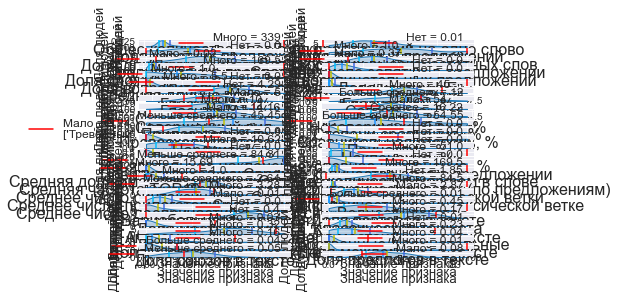

In [17]:
text_processor.visualize_text(text, person_public_df, public_df)

In [18]:
text_processor.get_table_of_morph_compare_with_sample(text, person_morph_df, morph_df)

алло алло алло. здравствуйте. так что вы хотите она лежит в больнице тихо тихо не было
логическое уже 0 месяц ну так что вы хотите от меня. мы вот. я знаю вот
смотрите мы сейчас это 0000 оставили на её карте вот. поняли. вот. ещё раз. сегодня вот мы. их оставили пожалуйста снимите да.
да да. да да да да ну. на следующей извините уже мы тоже постараемся но дело в том что она лежит
уже 0 в больнице вот честное слово я сегодня понесла справку это у нас вот борисовский это белгородская область борисовский район Борисовка вот и у меня её не
приняли что она лежит в больнице в общем то не принять и всё. да не. приняли ну а
мне говорят знаете что скажите конкретно кому что эту справку нужно вот вам если нужно вам пожалуйста её предоставлю. да. вы. что. ну какой. ый приказ.
это. извините. да вы что смеётесь буквально 0 0 месяца у нас внутри максимум 0 0 месяца. да домой не платили с как января вы что. вы в банк вы в
банк. ой я не знаю но она понимаете она весной лежал 0 месяца сейчас
лежит 0 ме

,Время,Доля в тексте,Cреднее по выборке,STD по выборке,Медиана по выборке,20% квантиль по выборке,80% квантиль по выборке,Слова
0,"Прошедшее, %",23.6,13.0,24.6,0.0,0.0,22.2,"[было, оставили, поняли, оставили, понесла, пр..."
1,"Настоящее, %",47.3,21.0,25.0,14.3,0.0,36.4,"[хотите, лежит, хотите, знаю, смотрите, лежит,..."
2,"Будущее, %",7.3,18.3,29.4,0.0,0.0,43.0,"[извините, постараемся, предоставлю, извините]"
3,"Абсолютное, %",7.3,43.1,34.5,40.0,0.0,83.3,"[принять, оставить, прислать, выйти]"


алло алло алло. здравствуйте. так что вы хотите она лежит в больнице тихо тихо не было логическое уже 0 месяц ну так что вы хотите от меня. мы вот. я знаю вот смотрите мы сейчас это 0000 оставили на её карте вот. поняли. вот. ещё раз. сегодня вот мы. их оставили пожалуйста снимите да. да да. да да да да ну. на следующей извините уже мы тоже постараемся но дело в том что она лежит уже 0 в больнице вот честное слово я сегодня понесла справку это у нас вот борисовский это белгородская область борисовский район Борисовка вот и у меня её не приняли что она лежит в больнице в общем то не принять и всё. да не. приняли ну а мне говорят знаете что скажите конкретно кому что эту справку нужно вот вам если нужно вам пожалуйста её предоставлю. да. вы. что. ну какой. ый приказ. это. извините. да вы что смеётесь буквально 0 0 месяца у нас внутри максимум 0 0 месяца. да домой не платили с как января вы что. вы в банк вы в банк. ой я не знаю но она понимаете она весной лежал 0 месяца сейчас лежит 0 ме

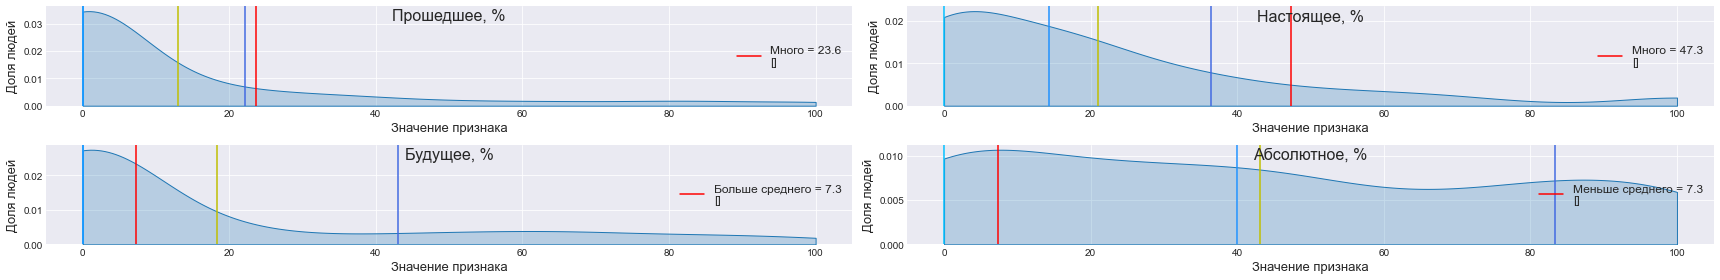

In [19]:
text_processor.visualize_text_morph(text, person_morph_df, morph_df)

In [20]:
text_processor.get_table_of_semantic_role_compare_with_sample(text, person_public_semantic_role_df, public_semantic_role_df)

алло алло алло. здравствуйте. так что вы хотите она лежит в больнице тихо тихо не было логическое уже 0 месяц ну так что вы хотите от
меня. мы вот. я знаю вот смотрите мы сейчас это 0000 оставили на её карте вот. поняли. вот. ещё раз. сегодня вот мы. их
оставили пожалуйста снимите да. да да. да да да да ну. на следующей извините уже мы тоже постараемся но дело в том что она лежит уже 0
в больнице вот честное слово я сегодня понесла справку это у нас вот борисовский это белгородская область борисовский район Борисовка вот и у меня её не
приняли что она лежит в больнице в общем то не принять и всё. да не. приняли ну а мне говорят знаете что скажите
конкретно кому что эту справку нужно вот вам если нужно вам пожалуйста её предоставлю. да. вы. что. ну какой. ый приказ. это. извините. да вы что
смеётесь буквально 0 0 месяца у нас внутри максимум 0 0 месяца. да домой не платили с как января вы что. вы в банк вы в банк. ой я не знаю но
она понимаете она весной лежал 0 месяца сейчас лежит 0 ме

,Конструкция,Количество в тексте,Cреднее по выборке,STD по выборке,Медиана по выборке,20% квантиль по выборке,80% квантиль по выборке,Словосочетания
0,Агенс,0.4,0.3,0.4,0.1,0.0,0.6,"[(знаю, я), (понесла, я), (предоставлю,), (зна..."
1,Пациенс,1.2,0.8,0.4,0.9,0.4,1.0,"[(здравствуйте,), (хотите,), (лежит,), (было,)..."
2,Внутренний предикат,0.5,0.1,0.2,0.0,0.0,0.2,"[(хотите,), (хотите,), (знаю,), (постараемся,)..."
3,Внешний предикат,0.6,0.4,0.3,0.4,0.1,0.6,"[(лежит,), (было,), (смотрите,), (снимите,), (..."


алло алло алло. здравствуйте. так что вы хотите она лежит в больнице тихо тихо не было логическое уже 0 месяц ну так что вы хотите от меня. мы вот. я знаю вот смотрите мы сейчас это 0000 оставили на её карте вот. поняли. вот. ещё раз. сегодня вот мы. их оставили пожалуйста снимите да. да да. да да да да ну. на следующей извините уже мы тоже постараемся но дело в том что она лежит уже 0 в больнице вот честное слово я сегодня понесла справку это у нас вот борисовский это белгородская область борисовский район Борисовка вот и у меня её не приняли что она лежит в больнице в общем то не принять и всё. да не. приняли ну а мне говорят знаете что скажите конкретно кому что эту справку нужно вот вам если нужно вам пожалуйста её предоставлю. да. вы. что. ну какой. ый приказ. это. извините. да вы что смеётесь буквально 0 0 месяца у нас внутри максимум 0 0 месяца. да домой не платили с как января вы что. вы в банк вы в банк. ой я не знаю но она понимаете она весной лежал 0 месяца сейчас лежит 0 ме

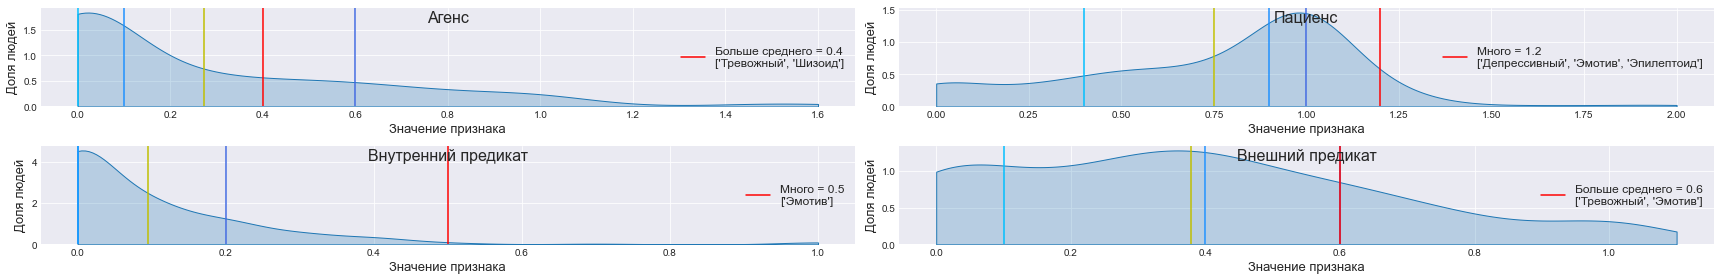

In [21]:
text_processor.visualize_text_semantic_role(text, person_public_semantic_role_df, public_semantic_role_df)

# Анализ модальностей

In [22]:
text_processor.table_by_text_modality(text, person_public_modality_df, public_modality_df)

алло алло алло. здравствуйте. так что вы хотите она лежит в больнице тихо тихо не было логическое уже 0 месяц ну так что вы хотите от меня. мы вот. я знаю вот смотрите мы сейчас
это 0000 оставили на её карте вот. поняли. вот. ещё раз. сегодня вот мы. их оставили пожалуйста снимите да. да да. да да да да ну. на следующей извините уже мы тоже постараемся но
дело в том что она лежит уже 0 в больнице вот честное слово я сегодня понесла справку это у нас вот борисовский это белгородская область борисовский район Борисовка вот и у меня её
не приняли что она лежит в больнице в общем то не принять и всё. да не. приняли ну а мне говорят знаете что скажите конкретно кому что эту справку нужно вот вам если нужно
вам пожалуйста её предоставлю. да. вы. что. ну какой. ый приказ. это. извините. да вы что смеётесь буквально 0 0 месяца у нас внутри максимум 0 0 месяца. да домой не платили с как
января вы что. вы в банк вы в банк. ой я не знаю но она понимаете она весной лежал 0 месяца сейчас лежит 0 ме

,Конструкция,Количество в тексте,Cреднее по выборке,STD по выборке,Медиана по выборке,20% квантиль по выборке,80% квантиль по выборке,Слова
0,Оптативная,0.0,0.4,1.2,0.0,0.0,0.0,[[]]
1,Гипотетическая и потенциальная,2.0,1.3,1.6,1.0,0.0,2.0,"[[можно, понимаете]]"
2,Интенция,2.0,1.8,2.6,1.0,0.0,3.0,"[[если, если]]"
3,Императив и дебитив,0.0,2.1,2.8,1.0,0.0,4.0,[[]]


# Психотипирование

In [23]:
text_processor.table_by_text_psyh_cosy(text, person_public_df, person_public_semantic_role_df, person_morph_df, public_df, public_semantic_role_df, morph_df)

алло алло алло. здравствуйте. так что вы хотите она лежит в больнице тихо тихо не было логическое
уже 0 месяц ну так что вы хотите от меня. мы вот. я знаю вот смотрите мы сейчас это 0000 оставили на её
карте вот. поняли. вот. ещё раз. сегодня вот мы. их оставили пожалуйста снимите да. да да. да да да да ну. на
следующей извините уже мы тоже постараемся но дело в том что она лежит уже 0 в больнице вот честное
слово я сегодня понесла справку это у нас вот борисовский это белгородская область борисовский
район Борисовка вот и у меня её не приняли что она лежит в больнице в общем то не принять и всё. да не.
приняли ну а мне говорят знаете что скажите конкретно кому что эту справку нужно вот вам если нужно вам
пожалуйста её предоставлю. да. вы. что. ну какой. ый приказ. это. извините. да вы что смеётесь буквально 0 0 месяца у нас
внутри максимум 0 0 месяца. да домой не платили с как января вы что. вы в банк вы в банк. ой я не
знаю но она понимаете она весной лежал 0 месяца сейчас лежит 0 ме

,Название характеристики,Истероид,Гипертим,Шизоид,Параноял,Эпилептоид,Депрессивный,Эмотив,Тревожный
0,Общее количество слов в тексте,-,-,-,-,-,-,-,-
1,Доля предложений на одно слово,-,-,-,-,-,-,-,-
2,Доля коротких предложений,-,-,-,-,-,-,-,-
3,Доля длинных предложений,-,-,"Много: 1.0 из (0.75, 1.0)",-,-,-,-,"Много: 1.0 из (0.75, 1.0)"
4,Доля длинных низкочастотных слов,"Мало: 0.02 из (0.0, 0.08)",-,-,"Мало: 0.02 из (0.0, 0.08)",-,-,-,-
...,...,...,...,...,...,...,...,...,...
59,Внешний предикат,-,-,-,-,-,-,"Больше среднего: 0.6 из (0.4, 0.6)","Больше среднего: 0.6 из (0.4, 0.6)"
60,"Прошедшее, %",-,-,-,-,-,-,-,-
61,"Настоящее, %",-,-,-,-,-,-,-,-
62,"Будущее, %",-,-,-,-,-,-,-,-


In [24]:
psychotype_by_text(text, person_public_df, person_public_semantic_role_df, public_df, public_semantic_role_df)

алло алло алло. здравствуйте. так что вы хотите она лежит в больнице тихо тихо не было логическое уже 0 месяц ну так что вы хотите от меня. мы вот. я знаю вот смотрите мы сейчас это 0000 оставили на её карте вот. поняли. вот. ещё раз. сегодня вот мы. их оставили пожалуйста снимите да. да да. да да да да ну. на следующей извините уже мы тоже постараемся но дело в том что она лежит уже 0 в больнице вот честное слово я сегодня понесла справку это у нас вот борисовский это белгородская область борисовский район Борисовка вот и у меня её не приняли что она лежит в больнице в общем то не принять и всё. да не. приняли ну а мне говорят знаете что скажите конкретно кому что эту справку нужно вот вам если нужно вам пожалуйста её предоставлю. да. вы. что. ну какой. ый приказ. это. извините. да вы что смеётесь буквально 0 0 месяца у нас внутри максимум 0 0 месяца. да домой не платили с как января вы что. вы в банк вы в банк. ой я не знаю но она понимаете она весной лежал 0 месяца сейчас лежит 0 ме

## * __Значение = Количество активировавшихся индикаторов психотипа__

,Шизоид,Тревожный,Параноял,Истероид,Паранял,Тревожый,Эпилептоид,Депрессивный,Эмотив,Гипертим
0,6,8,2,5,1,1,5,2,7,1


## * __Значение = Нормированный по l1-норме предыдущий вектор__

,Шизоид,Тревожный,Параноял,Истероид,Паранял,Тревожый,Эпилептоид,Депрессивный,Эмотив,Гипертим
0,0.16,0.21,0.05,0.13,0.03,0.03,0.13,0.05,0.18,0.03


In [25]:
text_processor.psychotype_by_text_elmo(text, person_public_dict_with_distances)

## * __Значение = Количество слов, близких к психотипу__

,Истероид,Шизоид,Эпилептоид,Эмотив
0,36,21,2,5


## * __Значение = Среднее расстояние от слов, близких к данному психотипу__

,Истероид,Шизоид,Эпилептоид,Эмотив
0,0.580278,0.569048,0.57,0.6


# Темперамент

In [26]:
df_with_features_ranges_temp_by_text(text, person_public_df, person_public_semantic_role_df, person_morph_df, public_df, public_semantic_role_df, morph_df)

,Название характеристики,Значение,Количество,Диапазон,Темперамент
0,Общее количество слов в тексте,339.00,Много,"(61.8, 151)",[]
1,Доля предложений на одно слово,0.01,Нет,"(0, 0.02)",[]
2,Доля коротких предложений,0.00,Нет,"(0, 0.0)",[]
3,Доля длинных предложений,1.00,Много,"(0.75, 1.0)",[Сангвиник]
4,Доля длинных низкочастотных слов,0.02,Мало,"(0.0, 0.08)","[Флегматик, Холерик]"
5,Доля коротких высокочастотных слов,0.37,Мало,"(0.27, 0.43)",[]
6,Средняя длина предложения,169.50,Много,"(16.33, 63.0)",[]
7,Среднее число запятых в предложении,0.00,Нет,"(0, 0.0)",[]
8,Доля сложноподчиненных предложений,1.00,Много,"(0.5, 1.0)",[Сангвиник]
9,Доля восклицательных предложений,0.00,Нет,"(0, 0.0)",[]


In [27]:
df_with_features_ranges_and_temp_by_text(text, person_public_df, person_public_semantic_role_df, person_morph_df, public_df, public_semantic_role_df, morph_df)

,Название характеристики,Меланхолик,Холерик,Флегматик,Сангвиник
0,Общее количество слов в тексте,-,-,-,-
1,Доля предложений на одно слово,-,-,-,-
2,Доля коротких предложений,-,-,-,-
3,Доля длинных предложений,-,-,-,"Много: 1.0 из (0.75, 1.0)"
4,Доля длинных низкочастотных слов,-,"Мало: 0.02 из (0.0, 0.08)","Мало: 0.02 из (0.0, 0.08)",-
...,...,...,...,...,...
59,Внешний предикат,"Больше среднего: 0.6 из (0.4, 0.6)",-,-,-
60,"Прошедшее, %",-,-,-,-
61,"Настоящее, %",-,-,-,-
62,"Будущее, %",-,-,-,-


In [28]:
temp_by_text(text, person_public_df, person_public_semantic_role_df, public_df, public_semantic_role_df)

алло алло алло. здравствуйте. так что вы хотите она лежит в больнице тихо тихо не было логическое уже 0 месяц ну так что вы хотите от меня. мы вот. я знаю вот смотрите мы сейчас это 0000 оставили на её карте вот. поняли. вот. ещё раз. сегодня вот мы. их оставили пожалуйста снимите да. да да. да да да да ну. на следующей извините уже мы тоже постараемся но дело в том что она лежит уже 0 в больнице вот честное слово я сегодня понесла справку это у нас вот борисовский это белгородская область борисовский район Борисовка вот и у меня её не приняли что она лежит в больнице в общем то не принять и всё. да не. приняли ну а мне говорят знаете что скажите конкретно кому что эту справку нужно вот вам если нужно вам пожалуйста её предоставлю. да. вы. что. ну какой. ый приказ. это. извините. да вы что смеётесь буквально 0 0 месяца у нас внутри максимум 0 0 месяца. да домой не платили с как января вы что. вы в банк вы в банк. ой я не знаю но она понимаете она весной лежал 0 месяца сейчас лежит 0 ме

## * __Значение = Количество активировавшихся индикаторов темперамента__

,Сангвиник,Флегматик,Холерик,Меланхолик
0,9,8,6,7


## * __Значение = Нормированный по l1-норме предыдущий вектор__

,Сангвиник,Флегматик,Холерик,Меланхолик
0,0.3,0.27,0.2,0.23


## Индикаторы шкалы "Хаотичная/Системная" (для Кронбаха)

In [29]:
text_processor.table_random_syst_by_token(text, person_public_df, df_for_rand_syst_indicators)

,Индикатор,Значение,Обратный квантиль
0,Доля гласных / Доля согласных,0,1.00
1,Несовершенный вид / Совершенный вид,0,0.87
2,Количество глаголов / Количество прилагательных,2,1.00
3,Количество наречий / Количество деепричастий,0,0.85
4,Количество причастий / Количество деепричастий,2,0.13
5,Доля условного наклонения / Доля повелительног...,2,0.52
6,Доля частиц НЕ среди всех слов,2,0.78
7,Хаотичная/Системная,2,-1.00


## Новая разметка от Руслана

In [30]:
text_processor.df_with_new_labels_by_text(text, person_df_for_new_labeling, public_df_for_new_labeling).T

,0
Текст,алло алло алло. здравствуйте. так что вы хотит...
Глаголы,1
Прилагательные,0
Наречия,1
Деепричастия,0
Причастия,0
Совершенная форма,0
Несовершенная форма,1
Простые предложения,0
Сложные предложения,1
